# Key recovery for loop randomization

This notebook focuses on the task of key recovery using different side-channel analysis methods.
All methods focus on _first order leakage_ as the loop randomization (i.e. hiding) does not require higher order analysis.

## Methods

A good overview and explanation of existing side-channel analysis methods can be found in [Power Side-Channel Attack Analysis: A Review of 20 Years of Study for the Layman](https://www.mdpi.com/2410-387X/4/2/15).

### CPA

A very common method is CPA.
Is uses the [Pearson Correlation Coefficient](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient) to reveal a _linear dependency_ between a predicted leakage and the actual traces.

The predictive value is free to choose: An entire key byte, it's hamming weight, a single bit, ...

## T-Test

The concept of side-channel analysis using [Welch's T-Test](https://en.wikipedia.org/wiki/Welch%27s_t-test) is to divide the recorded traces into two groups by a given _selection function_. The t-statistic gives a (unit-less) number which is high when the two sets "are different".

In classical DPA (e.g. [Power Side-Channel Attack Analysis: A Review of 20 Years of Study for the Layman](https://www.mdpi.com/2410-387X/4/2/15) 4.1) a _partition function_ is used to distinguish a set of traces into two distinct partitions.
Primarily the partition function focuses on a single bit of a computed value inside a cryptographic algorithm where a known part (mostly plaintext or ciphertext) collides with the secret key.
By partitioning with different key hypothesis one can "guess" the correct one: It is the partition where the two groups are most different from each other.

Kocher et al. proposed to use the "DoM (Difference of Means)" to compute a "difference" between two partitions.
The T-Test in contrast provides a better success rate [Empirical Comparison of Side Channel Analysis Distinguishers on DES in Hardware](https://www.esat.kuleuven.be/cosic/publications/article-1250.pdf).


Recovering the key from an AES SBOX lookup the following partition function can be used:

```python
sbox(plaintext[i] ^ guess) & (1 << b)
```

Considering the `i`-th byte and the `b`-th bit the total amount of partitions is $16 \cdot 8 \cdot 256 = 32768$.

## Signal-to-Noise Ratio (SNR)

> Signal-to-noise ratios are commonly used in electrical engineering and signal processing. An SNR is tbe ratio between tbe signal and tbe noise component of a measurement. The general definition of an SNR in a digital environment is given in (4.9).
> $$ SNR = \frac{Var(Signal)}{Var(Noise)} $$

(Mangard S., Oswald E., Popp T. Power Analysis Attacks.. Revealing the Secrets of Smart Cards (Advances in Information Security) (2007) 4.3.2)

For precise computation refer to [Advanced side-channel Measurement and Testing](https://hss-opus.ub.ruhr-uni-bochum.de/opus4/frontdoor/deliver/index/docId/8024/file/diss.pdf) (Formula 5.5).

$$ \mathrm{SNR} = \frac{
    \mathrm{Var}_{\forall k \in \mathcal S}(\mathbf{\bar x}_k)
}{
    \mathrm{E}_{\forall k \in \mathcal S}\big(\mathrm{Var}_{\forall i}(\mathbf{x}_{k,i})\big)
} $$

Similar to T-Test we can partition the set of traces into multiple subsets.
But, in contrast we don't have to focus on a single bit.
The entire byte or it's Hamming Weight can be considered.


## Comparison

A widely used criteria for comparing algorithms for key recovery is _ranking_.
Obviously, a method is "better" then another if the key can be revealed requiring less traces.
Hence, as we know the correct key (byte) a priori, we can check at which position in the ranking is occurs.

### Fictive example

We are guessing 256 possible key bytes. 
After including 10 traces into the first key recovery algorithm we see the correct key is only at position 200. 
For algorithm two it is a position 150.
This does not (yet) mean necessarily that algorithm one is better than two!

But, after 1000 traces we see that the correct key is also the best guess of algorithm one but only the 3rd best guess of algorithm two.
We realize that algorithm one is predominant to algorithm two.

In [1]:
%load_ext autoreload
%autoreload 2

import random

import lascar
import matplotlib.pyplot as plt
import numpy as np

import datasets
import key_recovery_loop

lascar.logger.setLevel(lascar.logging.CRITICAL)
plt.rcParams['figure.figsize'] = [15.0, 4.0]
plt.rcParams['figure.dpi'] = 140

## CWXMEGA Plain Fixedkey

First of all we throw the weakest implementation into the ring and compare the results.

In [2]:
dataset = datasets.dataset("cwxmega_plain_fixedkey")[:1000]

### CPA

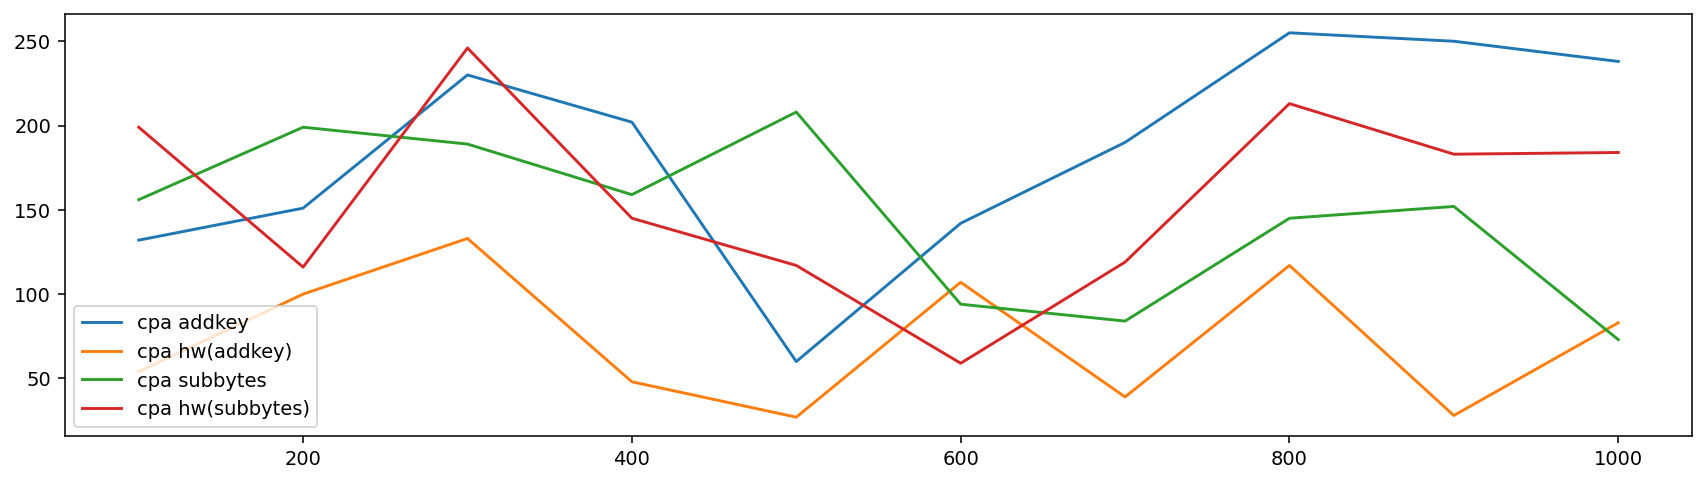

CPU times: user 2.67 s, sys: 8.68 s, total: 11.3 s
Wall time: 1.29 s


In [3]:
%%time

results = {
    name: key_recovery_loop.cpa(
        dataset=dataset,
        selection_function=selection_function,
        correct_key=dataset[0]["key"][1],
    )
    for name, selection_function in (
        ("cpa addkey", lambda value, guess: value[1] ^ guess),
        ("cpa hw(addkey)", lambda value, guess: lascar.hamming(value[1] ^ guess)),
        ("cpa subbytes", lambda value, guess: lascar.tools.aes.sbox[value[1] ^ guess]),
        ("cpa hw(subbytes)", lambda value, guess: lascar.hamming(lascar.tools.aes.sbox[value[1] ^ guess])),
    )
}

for name, result in results.items():
    plt.plot(*zip(*result), label=name)

plt.legend()
plt.show()

Unfortunately the result looks a bit weird. 
But it can be easily explained:

- `cpa subbytes` and `cpa hw(subbytes)` are so good that they even succeed in finding the correct key with the first couple of traces.
- `cpa addkey` and `cpa hw(addkey)` cannot reveal the key directly. But the correct key is always one out of the best two.

### T-Test

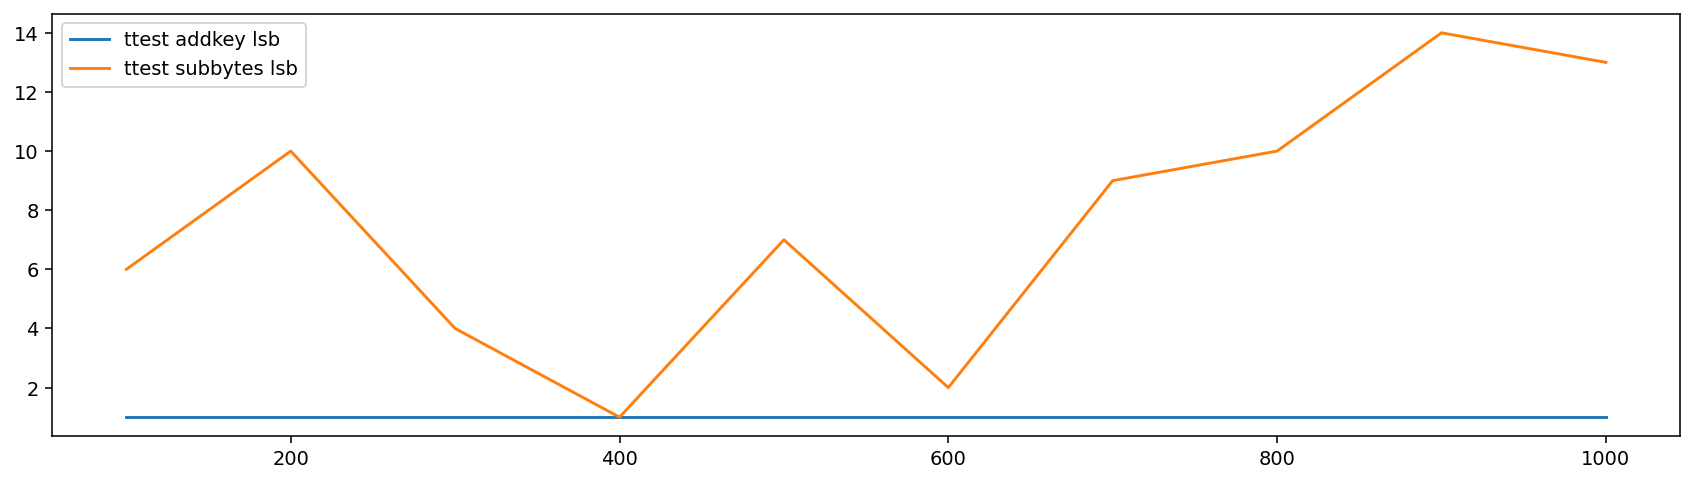

CPU times: user 11.5 s, sys: 222 ms, total: 11.7 s
Wall time: 11.6 s


In [4]:
%%time

def ttest_selection_addkey_lsb(guess):
    def selector(value):
        return (value[1] ^ guess) & 0x01
    return selector

def ttest_selection_subbytes_lsb(guess):
    def selector(value):
        return lascar.tools.aes.sbox[value[1] ^ guess] & 0x01
    return selector

results = {
    name: key_recovery_loop.ttest(
        dataset=dataset,
        selection_function=selection_function,
        correct_key=dataset[0]["key"][1],
    )
    for name, selection_function in (
        ("ttest addkey lsb", ttest_selection_addkey_lsb),
        ("ttest subbytes lsb", ttest_selection_subbytes_lsb),
    )
}

for name, result in results.items():
    plt.plot(*zip(*result), label=name)

plt.legend()
plt.show()


Again, not an interesting graph!

NOTE: For T-Test each guess requires a separate engine.
This increases the computational effort and we select 10 guesses randomly to keep the computation times handy.

### SNR

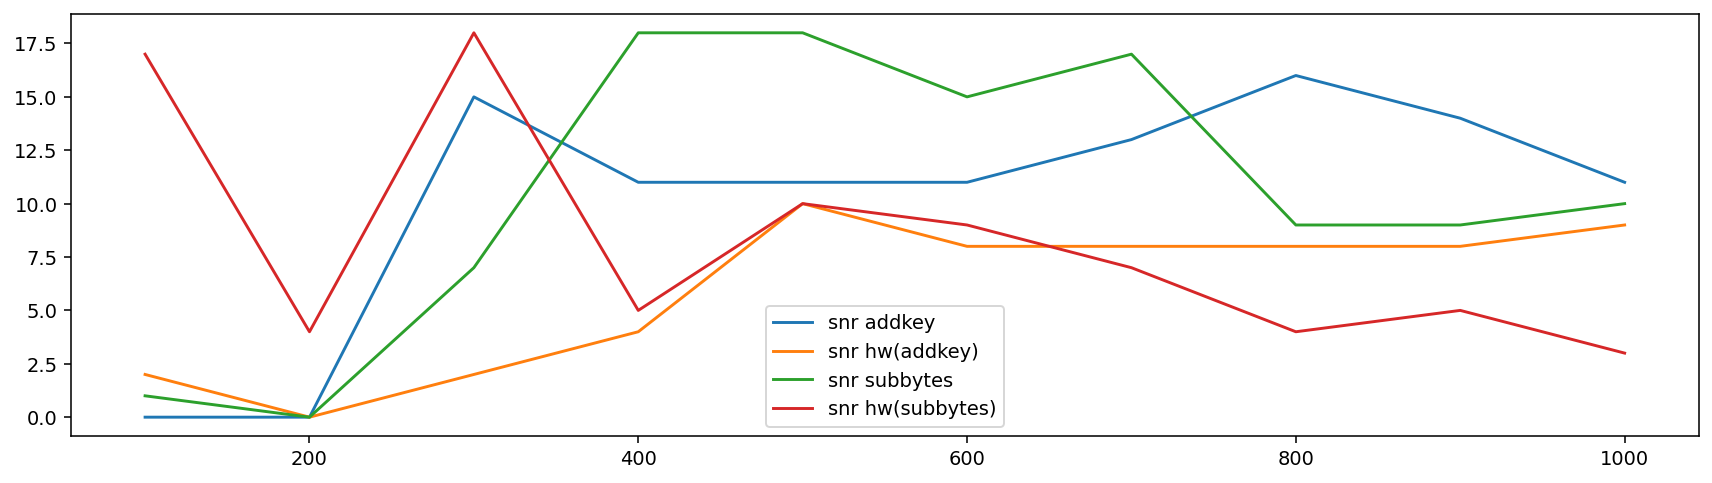

CPU times: user 25.7 s, sys: 296 ms, total: 26 s
Wall time: 25.7 s


In [5]:
%%time

def snr_selection_addkey(guess):
    def selector(value):
        return value[1] ^ guess
    return selector

def snr_selection_addkey_hw(guess):
    def selector(value):
        return lascar.hamming(value[1] ^ guess)
    return selector

def snr_selection_subbytes(guess):
    def selector(value):
        return lascar.tools.aes.sbox[value[1] ^ guess]
    return selector

def snr_selection_subbytes_hw(guess):
    def selector(value):
        return lascar.hamming(lascar.tools.aes.sbox[value[1] ^ guess])
    return selector

results = {
    name: key_recovery_loop.snr(
        dataset=dataset,
        selection_function=selection_function,
        selection_range=selection_range,
        correct_key=dataset[0]["key"][1],
    )
    for name, selection_function, selection_range in (
        ("snr addkey", snr_selection_addkey, range(256)),
        ("snr hw(addkey)", snr_selection_addkey_hw, range(9)),
        ("snr subbytes", snr_selection_subbytes, range(256)),
        ("snr hw(subbytes)", snr_selection_subbytes_hw, range(9)),
    )
}

for name, result in results.items():
    plt.plot(*zip(*result), label=name)

plt.legend()
plt.show()


### Results

We can see: The plain lookup without any side-channel countermeasures can be easily broken with every method.
At least for every method there is a selection/partition function which reveals the correct key in less than 100 traces.

In the following we focus only on the best selection functions.

## CWXMEGA Loop3 Fixedkey

Let's make the enemy a bit stronger!

In the following we use `cwxmega_loop3_fixedkey` and just the best "guesser" to compare CPA, T-Test and SNR.

In [6]:
dataset = datasets.dataset("cwxmega_loop3_fixedkey")[:4000]

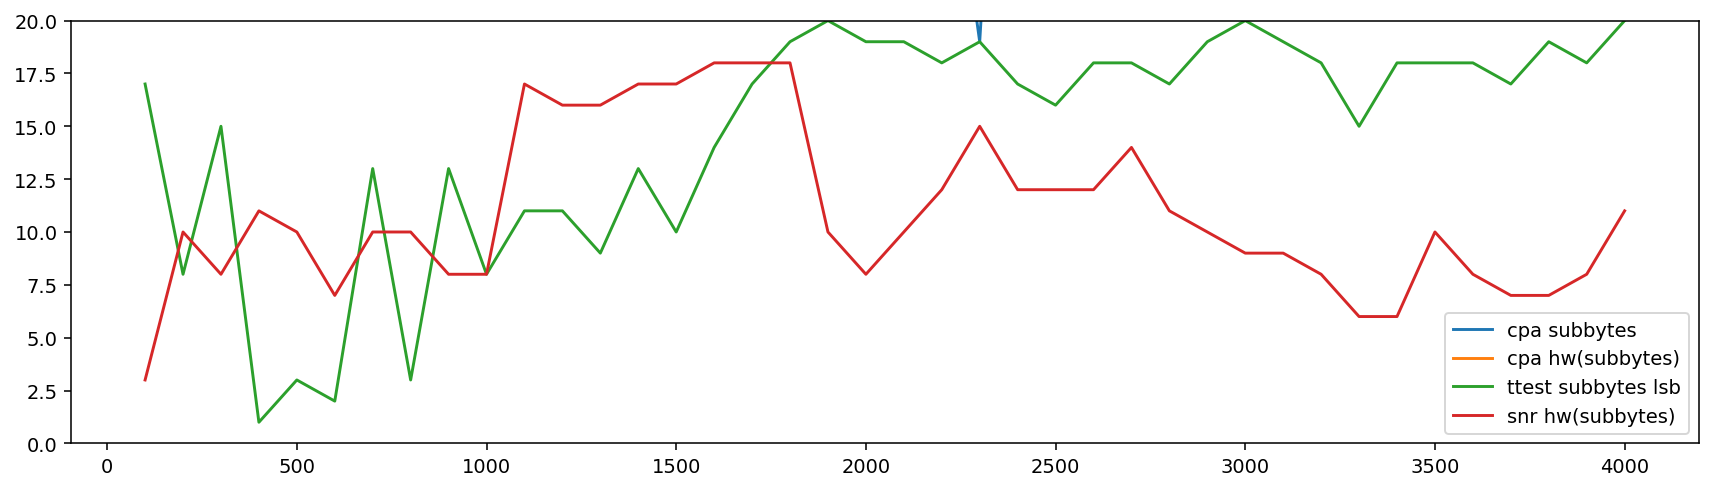

CPU times: user 16.1 s, sys: 9.36 s, total: 25.4 s
Wall time: 14.6 s


In [7]:
%%time

results = {
    "cpa subbytes": key_recovery_loop.cpa(
        dataset=dataset,
        selection_function=lambda value, guess: lascar.tools.aes.sbox[value[1] ^ guess],
        correct_key=dataset[0]["key"][1],
    ),
    "cpa hw(subbytes)": key_recovery_loop.cpa(
        dataset=dataset,
        selection_function=lambda value, guess: lascar.hamming(lascar.tools.aes.sbox[value[1] ^ guess]),
        correct_key=dataset[0]["key"][1],
    ),
    "ttest subbytes lsb": key_recovery_loop.ttest(
        dataset=dataset,
        selection_function=ttest_selection_subbytes_lsb,
        correct_key=dataset[0]["key"][1],
    ),
    "snr hw(subbytes)": key_recovery_loop.snr(
        dataset=dataset,
        selection_function=snr_selection_subbytes_hw,
        selection_range=range(9),
        correct_key=dataset[0]["key"][1],
    )
}

for name, result in results.items():
    plt.plot(*zip(*result), label=name)

plt.ylim([0, 20])
plt.legend()
plt.show()



We clearly see that CPA is superior to all other methods and that SNR has the worst performance.

This result is not surprising.
It was already stated in [Empirical Comparison of Side Channel Analysis Distinguishers on DES in Hardware](https://www.esat.kuleuven.be/cosic/publications/article-1250.pdf).

Note, that (luckily) CPA also provides the best performance. :-)

### Comments

- A direct comparison between lascar's CPA engine and a direct implementation using some nice numpy functions ([securec/cpa.py](https://github.com/hackenbergstefan/securec/blob/main/securec/cpa.py#L63)) shows that securec implementation is faster.
  But, for sake of simplicity we stick with lascar's `CpaEngine`.
- The author tried to outperform lascar's T-Test by a direct manual implementation. He failed.

## CWXMEGA Loops among each other

Finally we can compare how the side-channel countermeasures behave among each others.

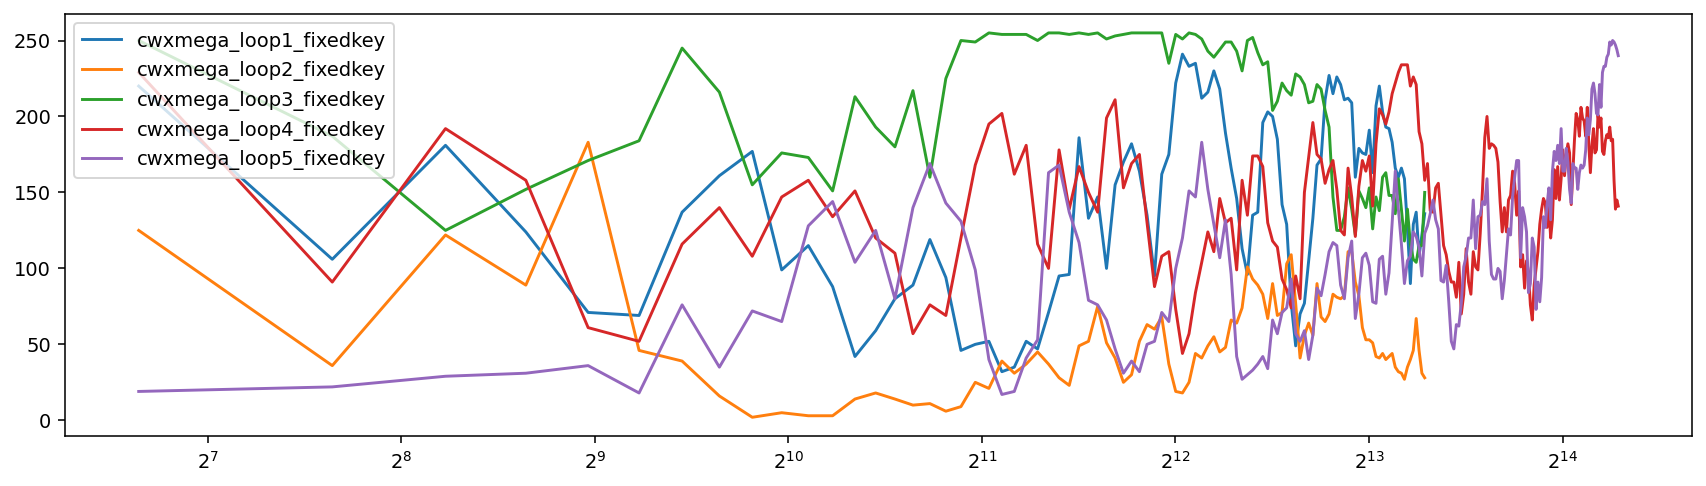

CPU times: user 11.8 s, sys: 45.9 s, total: 57.8 s
Wall time: 3.8 s


In [8]:
%%time

results = {
    dataset: key_recovery_loop.cpa(
        dataset=datasets.dataset(dataset),
        selection_function=lambda value, guess: lascar.hamming(lascar.tools.aes.sbox[value[1] ^ guess]),
        correct_key=datasets.dataset(dataset)[0]["key"][1],
    )
    for dataset in (
        "cwxmega_loop1_fixedkey",
        "cwxmega_loop2_fixedkey",
        "cwxmega_loop3_fixedkey",
        "cwxmega_loop4_fixedkey",
        "cwxmega_loop5_fixedkey",
    )
}

for name, result in results.items():
    plt.plot(*zip(*result), label=name)

plt.legend()
plt.xscale("log", base=2)
plt.show()

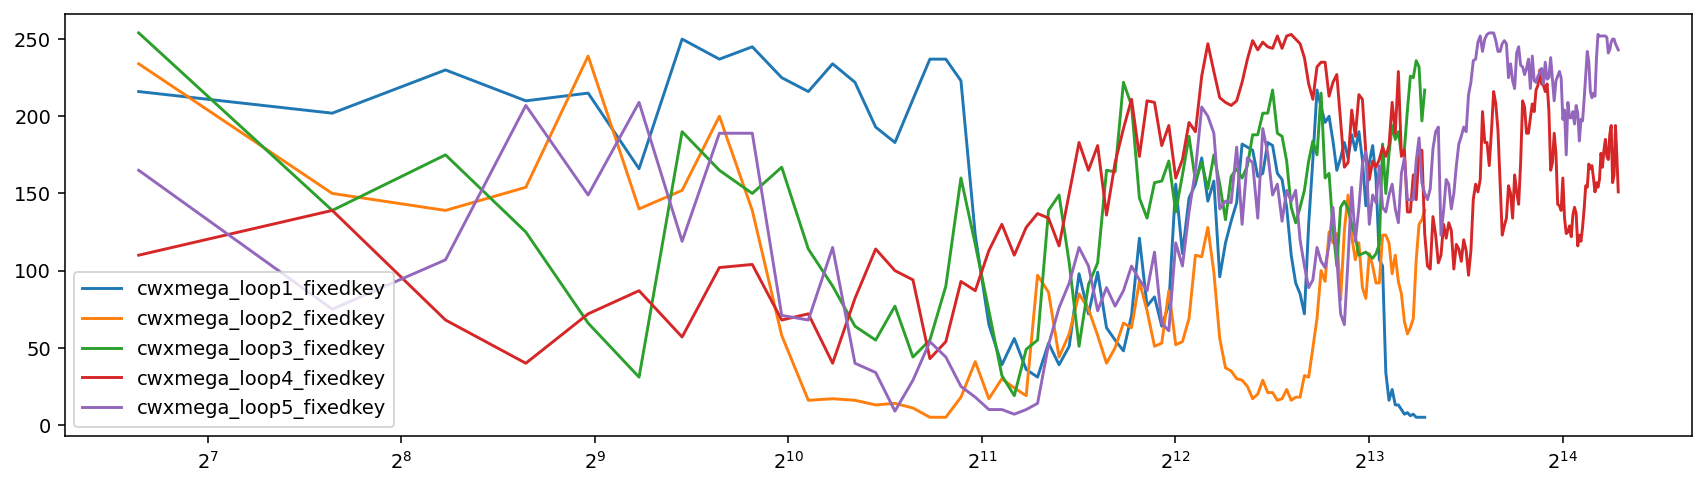

CPU times: user 14.6 s, sys: 1min 1s, total: 1min 16s
Wall time: 4.85 s


In [9]:
%%time

results = {
    dataset: key_recovery_loop.cpa(
        dataset=datasets.dataset(dataset),
        selection_function=lambda value, guess: lascar.tools.aes.sbox[value[1] ^ guess],
        correct_key=datasets.dataset(dataset)[0]["key"][1],
    )
    for dataset in (
        "cwxmega_loop1_fixedkey",
        "cwxmega_loop2_fixedkey",
        "cwxmega_loop3_fixedkey",
        "cwxmega_loop4_fixedkey",
        "cwxmega_loop5_fixedkey",
    )
}

for name, result in results.items():
    plt.plot(*zip(*result), label=name)

plt.legend()
plt.xscale("log", base=2)
plt.show()


We can clearly see that the Hamming weight model is superior to the byte model.
Be aware that this depends on the leakage behavior of the DUT.

## CWARM Loop3 Fixedkey

Let's consider our second trace source: ChipWhisperer Lite ARM.

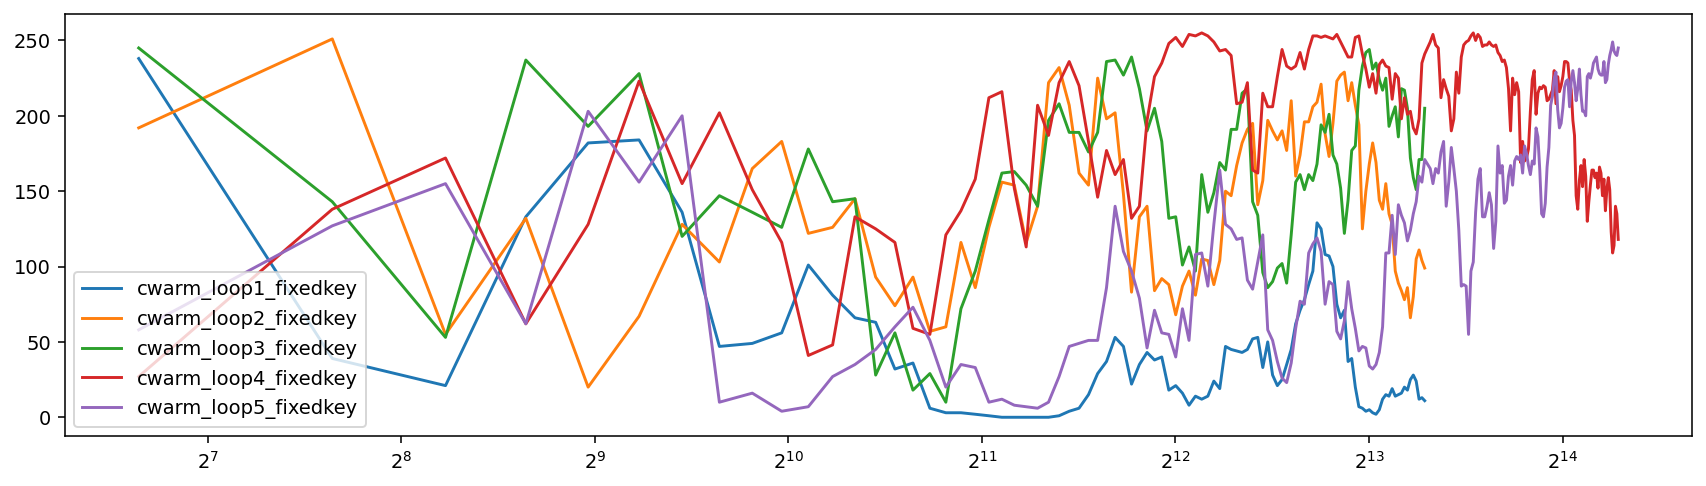

CPU times: user 14.4 s, sys: 52.2 s, total: 1min 6s
Wall time: 4.37 s


In [10]:
%%time

results = {
    dataset: key_recovery_loop.cpa(
        dataset=datasets.dataset(dataset),
        selection_function=lambda value, guess: lascar.hamming(lascar.tools.aes.sbox[value[1] ^ guess]),
        correct_key=datasets.dataset(dataset)[0]["key"][1],
    )
    for dataset in (
        "cwarm_loop1_fixedkey",
        "cwarm_loop2_fixedkey",
        "cwarm_loop3_fixedkey",
        "cwarm_loop4_fixedkey",
        "cwarm_loop5_fixedkey",
    )
}

for name, result in results.items():
    plt.plot(*zip(*result), label=name)

plt.legend()
plt.xscale("log", base=2)
plt.show()

Surprisingly (at least for me), CWARM leaks more than CWXMEGA!

## Summary

The key (more precise: one key byte) of `loop5`-security level can be revealed using CPA correlating the hamming weight of the SubBytes output after ~4000 traces on CWARM.
It cannot be revealed on CWXMEGA after 20.000 traces.